## Data Extraction & Exploration - Explore SA | The Gawler Challenge
###### Russell Menezes | RadixGEO

In these series of four notebooks I go though the **sarig_dh_details_exp** dataset and integrate it with the **sarig_rs_chem_exp** dataset. The focus here, is mainly on the different data ingestion and exploration techniques, with a special focus on working with large datasets. CSV's which are of the order of several GB in size are difficult to process as they can't opened and processed the conventional way on computers with standard RAM configurations. The final product at the end of this series may or may not be usefull to many but the techniques and ideas demonstrated here will definitely help you put together your own unique dataset on which, probably, the winning model will be built!

To summarize the four notebooks - 

1. We look at the *sarig_dh_details_exp.csv* file which seem to be the catalog containing meta-data for the drill holes. We explore and dissect this dataset to extract information on the gold commodity.

2. The *sarig_dh_details_Gold.csv* dataset is a massive file containging assay information on the drill holes in this region. In orderd to integrate this information with the catalog, we identify the row numbers that we need to extract from this massive csv which correspond to the drill hole numbers in the catalog dataset.

3. Here, we use the index (row) numbers obtained from the previous process to extract only those row numbers in chunks from the *sarig_dh_details_Gold.csv* dataset.

4. The two data sets we have now have a one to many relationship, i.e. for every DH number in the catalog file we have several rows of assay information. We explore techniques in this notebook on how to merge data with such relationships and present them effectively.

#### Notes:

1. This is my folder structure. If you are nunning these notebooks, please modify the file links to reflect your own folder structure

**ExploreSA**
* Cleaned_datasets
* Notebooks
* SARIG_Data_Package

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('h://ExploreSA/')
pd.set_option('display.max_columns', None)

### Starting with the Drill Hole catalog file

This file seems to have all the meta data related to all the bore holes for this project. We can use Pandas to load this data into a dataframe (DF) and start exploring.

In [2]:
df_details = pd.read_csv('6_Drilling/sarig_dh_details_exp.csv')

C:\Users\Russell\Anaconda3\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Information on Data in the spreadsheet

We can use pd.info() to get information on the column names, the data types and number of null values that each column contains.
The important things to abserve here are:
1. The dataframe has 51 columns and 315,374 rows.
2. Pandas identified three different data types.
3. You can see the number of valid data points for each column under the **Non-Null Count** column.

In [3]:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315375 entries, 0 to 315374
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DRILLHOLE_NO                315375 non-null  int64  
 1   DH_NAME                     185522 non-null  object 
 2   DH_OTHER_NAME               26295 non-null   object 
 3   PACE_DH                     315375 non-null  object 
 4   PACE_ROUND_NO               6534 non-null    float64
 5   REPRESENTATIVE_DH           315375 non-null  object 
 6   REPRESENTATIVE_DH_COMMENTS  91789 non-null   object 
 7   DH_UNIT_NO                  315375 non-null  object 
 8   MAX_DRILLED_DEPTH           297150 non-null  float64
 9   MAX_DRILLED_DEPTH_DATE      289698 non-null  object 
 10  CORED_LENGTH                51710 non-null   float64
 11  TENEMENT                    315375 non-null  object 
 12  OPERATOR_CODE               149879 non-null  object 
 13  OPERATOR_NAME 

### Date Column

Something that I like to do for data that has dates is convert the Date columns from a regular *object* data type to a *date time* one.
This makes it easier to access various attributes related to the date.

In [4]:
df_details.MAX_DRILLED_DEPTH_DATE = pd.to_datetime(df_details.MAX_DRILLED_DEPTH_DATE, infer_datetime_format=True)

### DF Preview

Let's preview the first 5 rows of the DF.
The columns that I feel are important at this stage are:

* MAX_DRILLED_DEPTH *(I don't want wells that are too deep at this stage)*
* MAX_DRILLED_DEPTH_DATE *(mordern wells have better data)*
* MINERAL_CLASS *(in order to exclude non mineral wells)*
* TARGET_COMMODITIES *(to look at a particular mineral deposit)*

In [5]:
df_details.head()

,DRILLHOLE_NO,DH_NAME,DH_OTHER_NAME,PACE_DH,PACE_ROUND_NO,REPRESENTATIVE_DH,REPRESENTATIVE_DH_COMMENTS,DH_UNIT_NO,MAX_DRILLED_DEPTH,MAX_DRILLED_DEPTH_DATE,CORED_LENGTH,TENEMENT,OPERATOR_CODE,OPERATOR_NAME,TARGET_COMMODITIES,MINERAL_CLASS,PETROLEUM_CLASS,STRATIGRAPHIC_CLASS,ENGINEERING_CLASS,SEISMIC_POINT_CLASS,WATER_WELL_CLASS,WATER_POINT_CLASS,DRILLING_METHODS,STRAT_LOG,LITHO_LOG,PETROPHYSICAL_LOG,GEOCHEMISTRY,PETROLOGY,BIOSTRATIGRAPHY,SPECTRAL_SCANNED,CORE_LIBRARY,REFERENCES,HISTORICAL_DOCUMENTS,COMMENTS,MAP_250000,MAP_100000,MAP_50K_NO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,HORIZ_ACCRCY_M,ELEVATION_M,INCLINATION,AZIMUTH,SURVEY_METHOD_CODE,SURVEY_METHOD
0,1,GINGERAH HILL 1,NaN,N,NaN,N,NaN,3359 1,1473.50,1986-09-14,NaN,,NaN,NaN,NaN,N,Y,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,NaN,SE5114 MUNRO,3359 Cudalgarra,2,124,433537.93,7847062.23,51,122.366742,-19.469838,122.366734,-19.469824,NaN,NaN,NaN,NaN,NaN,NaN
1,2,BROOKE 1,NaN,N,NaN,N,NaN,3458 1,2035.10,1988-07-21,NaN,,NaN,NaN,NaN,N,Y,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,N,NaN,SE5114 MUNRO,3458 Brooke,1,125,491238.13,7816262.34,51,122.916370,-19.749266,122.916362,-19.749252,NaN,NaN,NaN,NaN,NaN,NaN
2,3,SAHARA 1,NaN,N,NaN,N,NaN,3555 1,2120.19,1965-02-26,NaN,,NaN,NaN,NaN,N,Y,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,Y,NaN,SF5107 SAHARA,3555 Tandalgoo,1,126,540836.18,7674882.10,51,123.392991,-21.026384,123.392983,-21.026370,200.0,NaN,NaN,NaN,MAP,Map Plot
3,4,NYALAYI 1/90,NaN,N,NaN,N,NaN,3743 1,96.00,1990-12-06,NaN,,NaN,NaN,Water,N,N,N,N,N,Y,N,Rotary,N,Y,N,N,N,N,N,N,Y,Y,NaN,SG5115 THROSSELL,3743 Buldya,1,127,647138.76,6991660.71,51,124.485432,-27.189890,124.485424,-27.189876,NaN,NaN,NaN,NaN,NaN,NaN
4,5,GAMBANGA 1,NaN,N,NaN,N,NaN,3833 1,391.06,1960-03-05,NaN,,NaN,NaN,NaN,N,Y,N,N,N,N,N,NaN,N,N,N,N,N,N,N,N,N,Y,NaN,SI5104 CULVER,3833 Price,3,128,664137.34,6426048.14,51,124.743123,-32.290334,124.743116,-32.290320,NaN,NaN,NaN,NaN,NaN,NaN


### Count of wells drilled per year

I'm using Seaborn's count plot to plot the number of wells drilled every year. There are very few wells drilled until 1994 and the count starts increasing from there. At this stage, I'll exclude wells drilled before 1994 *(That is before the spike in the plot)*.

Note how I am accessing the Year attribute from the date column. This is because we converted the column into a date time format. Try running the df_details.info() command again to see the data type for the *MAX_DRILLED_DEPTH_DATE* column.

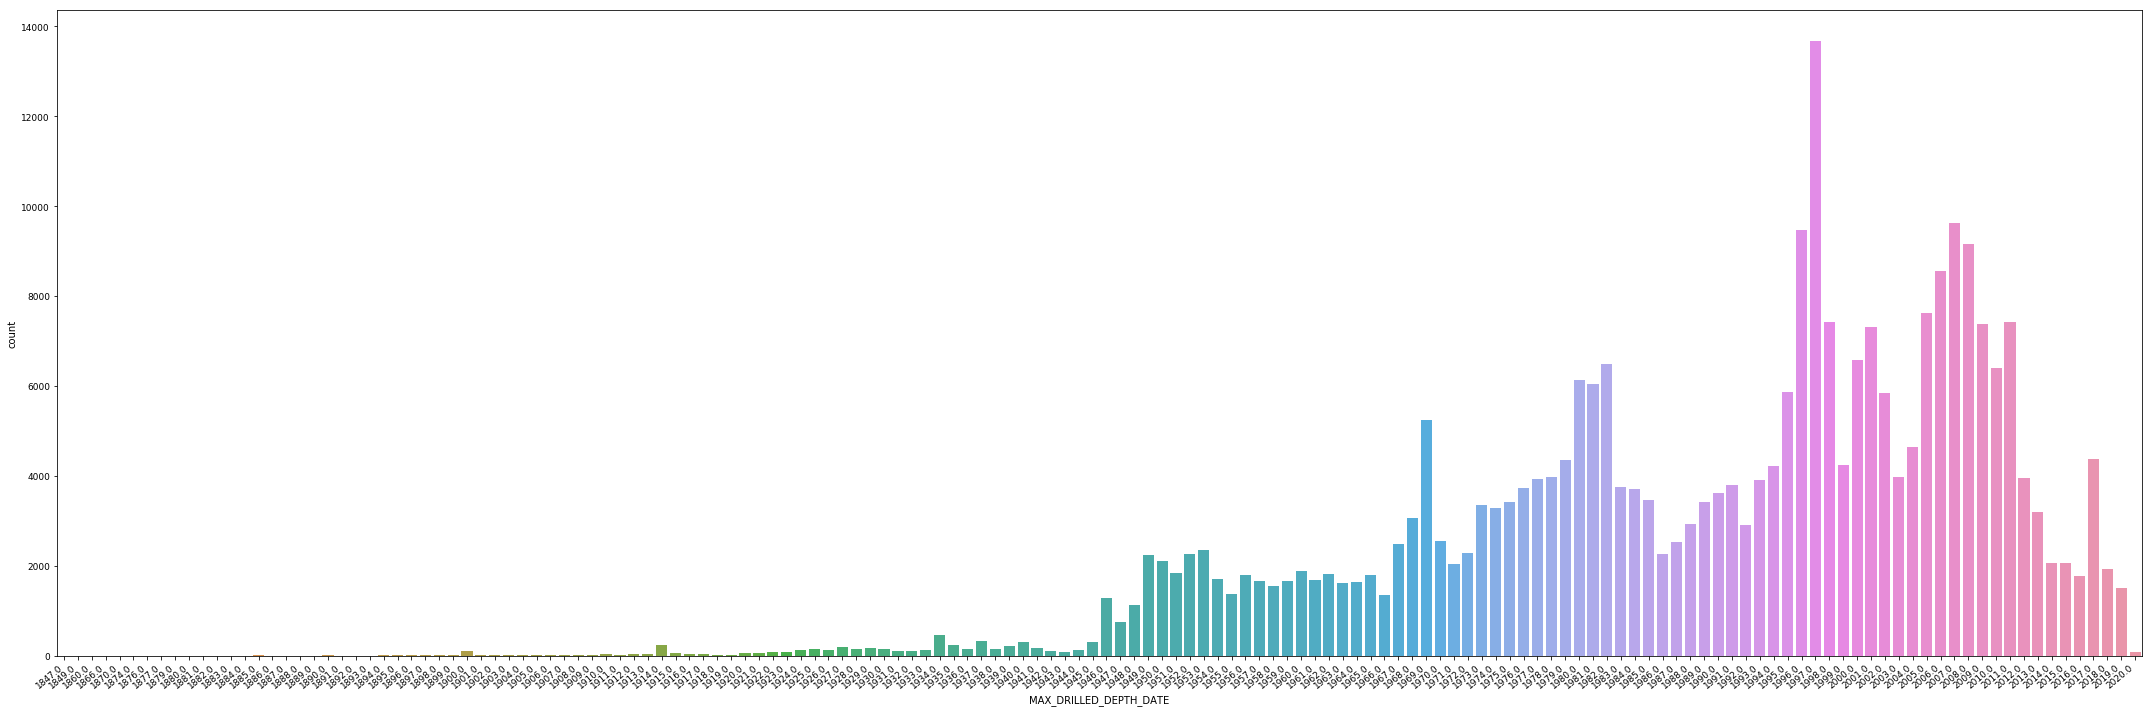

In [9]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x=df_details.MAX_DRILLED_DEPTH_DATE.dt.year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

We now create a new DF to only include wells drilled after the year 1994. By checking the shape of the new DF, you can observe that the number of bore holes are reduced by more than half.

In [12]:
df_new = df_details[df_details.MAX_DRILLED_DEPTH_DATE.dt.year > 1994]

In [14]:
print('Number of rows in original DF: {}'.format(len(df_details)))
print('Number of rows in new DF: {}'.format(len(df_new)))

Number of rows in original DF: 315375
Number of rows in new DF: 146159


Another look at the distribution count for the wells drilled.

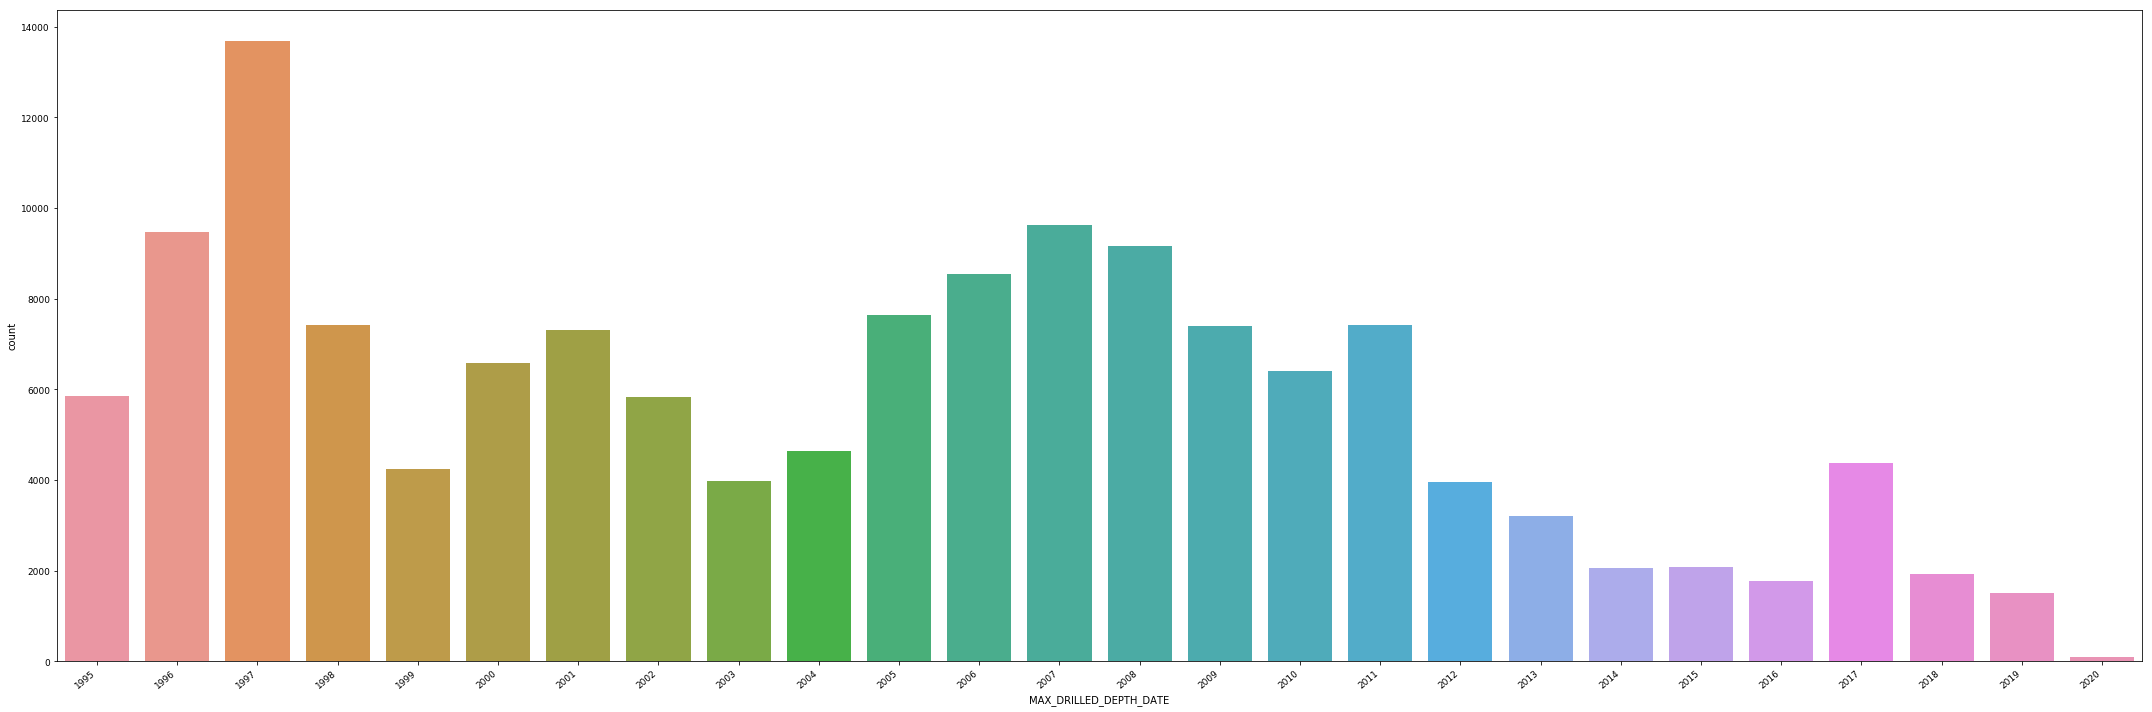

In [15]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x=df_new.MAX_DRILLED_DEPTH_DATE.dt.year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

### Filter out non-mineral class wells

Since I'm only interested in looking at mineral wells. Number of boreholes dropped to ~92k now.

In [19]:
df_new = df_new[df_new.MINERAL_CLASS == 'Y']

In [20]:
print('Number of rows in new DF: {}'.format(len(df_new)))

Number of rows in new DF: 92670


### Gold

In the next few steps I'll extract boreholes that were looking at gold deposits. Look at the comments in the code cells for an explanation of the steps.

In [21]:
#Creating a unique list of commodities from the TARGET_COMMODITIES column

target_commodities = df_new.TARGET_COMMODITIES.dropna().unique()
target_commodities

array(['Water', 'Base Metals, Heavy Minerals', 'Water, Zinc',
       'Gold, Copper', 'Uranium',
       'Gold, Base Metals, Metalliferous Minerals',
       'Gold, Base Metals, Iron', 'Gold, Base Metals', 'Gypsum',
       'Gypsum, Water', 'Coal', 'Base Metals', 'Lead, Zinc', 'Copper',
       'Diamond', 'Gold, Copper, Iron', 'Gold, Base Metals, Copper',
       'Sand', 'Copper, Lead, Zinc', 'Base Metals, Lead, Zinc', 'Iron',
       'Gold, Copper, Lead, Zinc', 'Silver, Gold, Lead, Zinc', 'Garnet',
       'Gold', 'Gold, Base Metals, Diamond', 'Celestite, Dolomite',
       'Diatomite', 'Silver, Gold, Copper, Rare Earths, Uranium',
       'Gold, Diamond', 'Gold, Base Metals, Copper, Diamond',
       'Silver, Copper, Lead, Zinc', 'Base Metals, Iron',
       'Silver, Lead, Zinc', 'Evaporites, Heavy Minerals',
       'Heavy Minerals', 'Copper, Nickel', 'Silver, Gold, Copper',
       'Base Metals, Diamond, Heavy Minerals', 'Evaporites, Rare Earths',
       'Gold, Base Metals, Evaporites', 'Gold, C

In [22]:
#Extracting names from the list which contain Gold

target_commodities_gold = [i for i in target_commodities if 'gold' in i.lower()]
target_commodities_gold

['Gold, Copper',
 'Gold, Base Metals, Metalliferous Minerals',
 'Gold, Base Metals, Iron',
 'Gold, Base Metals',
 'Gold, Copper, Iron',
 'Gold, Base Metals, Copper',
 'Gold, Copper, Lead, Zinc',
 'Silver, Gold, Lead, Zinc',
 'Gold',
 'Gold, Base Metals, Diamond',
 'Silver, Gold, Copper, Rare Earths, Uranium',
 'Gold, Diamond',
 'Gold, Base Metals, Copper, Diamond',
 'Silver, Gold, Copper',
 'Gold, Base Metals, Evaporites',
 'Gold, Chromium',
 'Gold, Chromium, Nickel',
 'Gold, Copper, Molybdenum',
 'Silver, Gold, Copper, Lead, Zinc',
 'Silver, Gold, Copper, Uranium',
 'Silver, Gold, Copper, Lead, Water, Zinc',
 'Gold, Water',
 'Silver, Gold, Base Metals, Copper, Lead, Uranium, Zinc',
 'Gold, Copper, Diamond, Iron, Heavy Minerals',
 'Gold, Copper, Diamond',
 'Gold, Base Metals, Nickel, Platinoids',
 'Gold, Heavy Minerals',
 'Gold, Copper, Nickel, Zinc',
 'Gold, Copper, Iron Ore',
 'Gold, Cobalt, Copper',
 'Gold, Copper, Iron, Lead, Zinc',
 'Gold, Uranium',
 'Gold, Platinoids',
 'Silver, 

In [23]:
#Creating a new DF to include only those commodites from the 'target_commodities_gold' list

df_new_gold = df_new[df_new.TARGET_COMMODITIES.isin(target_commodities_gold)]

In [24]:
print('Number of rows in df_new_gold: {}'.format(len(df_new_gold)))

Number of rows in df_new_gold: 41979


Now that we have filtered out boreholes that are younger than 1994, are mineral wells and contain Gold as a target commodity, let us look at a small random sample of data.

In [25]:
df_new_gold.sample(5)

,DRILLHOLE_NO,DH_NAME,DH_OTHER_NAME,PACE_DH,PACE_ROUND_NO,REPRESENTATIVE_DH,REPRESENTATIVE_DH_COMMENTS,DH_UNIT_NO,MAX_DRILLED_DEPTH,MAX_DRILLED_DEPTH_DATE,CORED_LENGTH,TENEMENT,OPERATOR_CODE,OPERATOR_NAME,TARGET_COMMODITIES,MINERAL_CLASS,PETROLEUM_CLASS,STRATIGRAPHIC_CLASS,ENGINEERING_CLASS,SEISMIC_POINT_CLASS,WATER_WELL_CLASS,WATER_POINT_CLASS,DRILLING_METHODS,STRAT_LOG,LITHO_LOG,PETROPHYSICAL_LOG,GEOCHEMISTRY,PETROLOGY,BIOSTRATIGRAPHY,SPECTRAL_SCANNED,CORE_LIBRARY,REFERENCES,HISTORICAL_DOCUMENTS,COMMENTS,MAP_250000,MAP_100000,MAP_50K_NO,SITE_NO,EASTING_GDA2020,NORTHING_GDA2020,ZONE_GDA2020,LONGITUDE_GDA2020,LATITUDE_GDA2020,LONGITUDE_GDA94,LATITUDE_GDA94,HORIZ_ACCRCY_M,ELEVATION_M,INCLINATION,AZIMUTH,SURVEY_METHOD_CODE,SURVEY_METHOD
203143,212875,SAM5,NaN,N,NaN,Y,NaN,6933 620,60.0,1998-09-24,NaN,EL 2688,AEP3,Aberfoyle Resources Ltd.,"Gold, Base Metals",Y,N,N,N,N,N,N,Reverse Circulation Percussion,N,N,N,Y,N,N,N,N,Y,N,Tenement Operator: MIM Exploration Pty Ltd.,SI5402 OLARY,6933 Olary,1,1104841,444923.69,6450159.52,54,140.416381,-32.083503,140.416371,-32.083489,0.01,NaN,-60.0,3.0,DOCM,"Sourced from documents (PLANS, ENV, RB,etc)"
229409,241188,1018,NaN,N,NaN,N,Commonwealth Hill-Birthday Prospect,5638 6423,20.0,1996-10-30,NaN,EL 1900,MNN,Minotaur Gold NL.,Gold,Y,N,N,N,N,N,N,Rotary Air Blast (see also RTA),N,N,N,Y,N,N,N,N,Y,N,Drilling for gold anomalies identified in regi...,SH5306 COOBER PEDY,5638 Jumbuck,2,1426483,396825.36,6689833.44,53,133.931163,-29.917886,133.931154,-29.917872,20.00,186.68,-60.0,90.0,GPS,Global Positioning System
211238,222860,CHRC016,NaN,N,NaN,N,Mount Woods area,5939 893,150.0,2005-09-10,NaN,EL 2781,GSU,Goldstream Mining NL.,"Gold, Copper, Nickel",Y,N,N,N,N,N,N,Reverse Circulation Percussion,N,N,N,Y,N,N,N,N,Y,N,Anomalous PGE in the Mt Woods area.,SH5307 BILLA KALINA,5939 Engenina,3,1139386,511466.83,6758753.56,53,135.118072,-29.300152,135.118063,-29.300138,10.00,141.00,-60.0,0.0,GPSAP,GPS Averaged Position
231796,243595,11789,NaN,N,NaN,N,Auger drilling program Kanmantoo Prospect.,6627 12718,3.0,1997-03-15,NaN,EL 1965,PII,Pima Mining NL.,"Gold, Base Metals",Y,N,N,N,N,N,N,Auger (Mechanised),N,N,N,Y,N,N,N,N,Y,N,NaN,SI5413 BARKER,6627 Milang,1,1436173,310662.46,6101754.74,54,138.919947,-35.209383,138.919937,-35.209368,10.00,170.97,-90.0,0.0,GPSSN,GPS Standalone Navigational
198703,208341,MLK 163,NaN,N,NaN,Y,Moolkra Prospect,5836 1438,8.5,1998-07-29,NaN,EL 2091,MIM,Mount Isa Mines Ltd.,"Gold, Base Metals",Y,N,N,N,N,N,N,Rotary Air Blast (see also RTA),N,N,N,Y,N,N,N,N,Y,N,"35 km South-East from Tarcoola, Gawler Craton",SH5310 TARCOOLA,5836 Tarcoola,2,1071836,495529.78,6584772.53,53,134.953238,-30.870286,134.953228,-30.870272,0.01,138.55,-90.0,0.0,DOCM,"Sourced from documents (PLANS, ENV, RB,etc)"


### Well Depths

I'm curious about the depths of the wells. Some of them had quiet high values. Lets create a quick histogram to check the distribution for the **MAX_DRILLED_DEPTH** column. Majority of the data seems to be less than 500m deep. Taking out the petroleum wells seemed to take off a lot of the deeper wells.

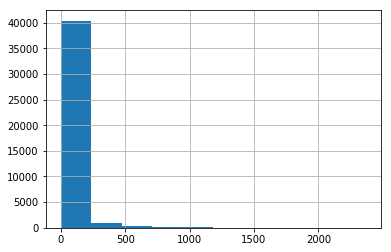

In [26]:
df_new_gold.MAX_DRILLED_DEPTH.hist()

Exporting this for use later

In [28]:
df_new_gold.to_csv('Cleaned_datasets/sarig_dh_details_Gold.csv', index=False)